In [1]:
# required imports for the function here
# some of these might be extraneous since they're just being grabbed from the total pipeline
# but right now, we just need to make some catalogs!
%matplotlib inline

import numpy as np
from numpy.lib.recfunctions import append_fields
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import halotools.mock_observables as mo
import halotools.sim_manager as sm
import astropy.coordinates as coord

In [2]:
fname = './l0250_d200b.catalog' # file name to z0.0.catalog
mthresh = 7e11  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 250.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data_master = reader.read_ascii()

fname = './l0250_d70b.catalog' # file name to z0.0.catalog
mthresh = 9e11  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 250.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data_matching = reader.read_ascii()


...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0250_d200b.catalog
 
Total number of rows in detected data = 2342337
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 20.95 seconds



...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0250_d70b.catalog
 
Total number of rows in detected data = 2535889
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 22.68 seconds




In [3]:
c_master = coord.SkyCoord(x=hosts_data_master['halo_x'], y=hosts_data_master['halo_y'], z=hosts_data_master['halo_z'],
                         unit='Mpc', frame='icrs', representation='cartesian')

In [4]:
c_matching = coord.SkyCoord(x=hosts_data_matching['halo_x'], y=hosts_data_matching['halo_y'], z=hosts_data_matching['halo_z'],
                            unit='Mpc', frame='icrs', representation='cartesian')

In [5]:
idx, sep2d, sep3d = coord.match_coordinates_3d(c_matching, c_master)

In [6]:
np.percentile(sep3d,70)

0.00035845501565418285

In [7]:
mask = (sep3d.value <= hosts_data_matching['halo_rvir']*.001*.1)
othermask = idx[np.where(sep3d.value <= hosts_data_matching['halo_rvir']*.001*.1)]

In [8]:
mask

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [9]:
print len(mask), np.sum(mask)

87918 86438


In [10]:
matched_catalog = hosts_data_matching[np.where(mask==True)]
matched_catalog_master = hosts_data_master[othermask]

In [11]:
len(matched_catalog), len(matched_catalog_master)

(86438, 86438)

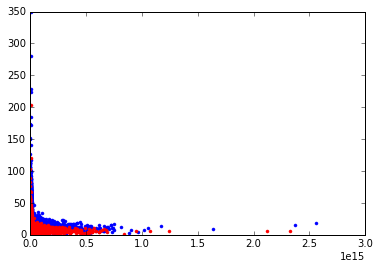

In [12]:
plt.plot(matched_catalog['halo_mass'], matched_catalog['halo_rvir']/matched_catalog['halo_rs'],
         'b.')
plt.plot(matched_catalog_master['halo_mass'], matched_catalog_master['halo_rvir']/matched_catalog_master['halo_rs'],
         'r.')

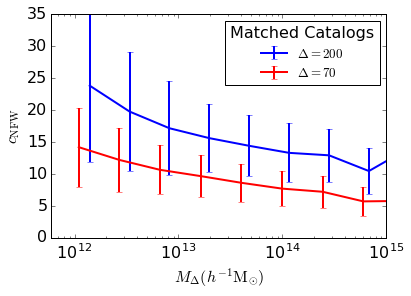

In [15]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3

total_bins = 10

X1 = np.log10(matched_catalog['halo_mass'])
Y1 = matched_catalog['halo_rvir']/matched_catalog['halo_rs']
X2 = np.log10(matched_catalog_master['halo_mass'])
Y2 = matched_catalog_master['halo_rvir']/matched_catalog_master['halo_rs']


bins = np.linspace(X1.min(),X1.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X1,bins)
running_median = [np.median(Y1[idx==k]) for k in range(total_bins)]

running_std    = [Y1[idx==k].std() for k in range(total_bins)]
scatter_200 = [running_std[k]/running_median[k] for k in range(total_bins)]
plt.errorbar(10**(bins-delta/2),running_median,
              running_std, color='b', label=r'$\Delta=200$', lw=2)

bins = np.linspace(X2.min(),X2.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X2,bins)
running_median = [np.median(Y2[idx==k]) for k in range(total_bins)]

running_std    = [Y2[idx==k].std() for k in range(total_bins)]
scatter_70 = [running_std[k]/running_median[k] for k in range(total_bins)]
plt.errorbar(10**(bins-delta/2),running_median,
              running_std, color='r', label=r'$\Delta=70$', lw=2)

plt.xscale('log')
plt.xlim(6e11,1e15)
plt.ylim(0,35)
plt.legend(loc='upper right', numpoints=1, prop={'size': 13}, title='Matched Catalogs')
plt.xlabel(r'$M_{\Delta} (h^{-1}\mathrm{M}_{\odot})$')
plt.ylabel(r'$c_{\mathrm{NFW}}$')
plt.savefig('./FIGS/matched_catalog_cnfwcomp.pdf')

In [20]:
data_200 = [0.5012, 0.4714, 0.4319, 0.3419, 0.3308, 0.3475, 0.3214, 0.3527, 0.1862]
data_70 = [0.4375, 0.4132, 0.3641, 0.3376, 0.3420, 0.3524, 0.3465, 0.4042, 0.0343]
print np.mean(data_200), np.std(data_200)
print np.mean(data_70), np.std(data_70)

0.365 0.0884296330423
0.336866666667 0.112119400641
